In [25]:
# Mount Drive Folder to Colab [Local]
from google.colab import drive
drive.mount("/content/gdrive")

!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/learnings/learn\ Semantic\ Segmentation
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
ln: failed to create symbolic link '/mydrive/My Drive': File exists
/content/gdrive/.shortcut-targets-by-id/1hY7OXouwq0fy6H5SKai7S5KUOD1KC9qg/learn Semantic Segmentation
imgDataSet			     SAM_Seg.ipynb	   yolo_sam.ipynb
learn_yolov8_sem_segmantation.ipynb  sam_vit_h_4b8939.pth  yolov8n.pt
runs				     yolo11n.pt


In [10]:
!nvidia-smi
!pip install git+https://github.com/facebookresearch/segment-anything.git

Mon Jun 30 10:45:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Download SAM weights (ViT-H)
# !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [11]:
import os
import random
import cv2 as cv
import torch
import matplotlib.pyplot as plt
import numpy as np

In [12]:
image_folder = 'imgDataSet/test/images'

In [13]:
def randomly_selected_images(image_path, num_selected=1):
  all_images = [image for image in os.listdir(image_path) if image.lower().endswith((".png",".jpg",".jpeg"))]
  if len(all_images) == 0:
    print("Empty image folder")
    return []

  num_img = min(num_selected, len(all_images))
  selected = all_images[:num_selected]
  # selected = random.sample(all_images, num_img)
  print(f"\033[92mSelected {num_img} images:\033[0m {selected}")
  return selected

In [14]:
# Segment Anything by Facebook [SAM Model]
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [15]:
# SAM Masking
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

# def show_mask(mask, ax, color=(1,1,1), alpha=0.8, random_color=False):
#   mask_image = np.zeros((mask.shape[0], mask.shape[1], 4), dtype=np.uint8)
#   for i in range(3):
#     mask_image[:,:, i] = mask * color[i] * 255
#   mask_image[:,:, 3] = mask * alpha * 255
#   ax.imshow(mask_image)

# def show_points(coords, labels, ax, marker_size=375):
#   for point, label in zip(coords, labels):
#     color = 'green' if label == 1 else 'red'
#     ax.scatter(point[0], point[1], color=color, marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

# def show_box(box, ax):
#     x0, y0 = box[0], box[1]
#     w, h = box[2] - box[0], box[3] - box[1]
#     ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [16]:
# Values of Points and Boxes
selected_images = randomly_selected_images(image_folder)

points = {
    selected_images[0]:{
      "input_points": np.array([[872, 627],[1430, 414],[1110, 900]]),
      "input_labels": np.array([1, 1, 0])
      },
}

boxes = {
    selected_images[0]:{
      "input_boxes": np.array([
          [715, 375, 1047, 878],
          [1170, 206, 1692, 562],
          [902, 745, 1303, 1050]
        ]),
    },
}

Selected 1 images: ['IMG_20250627_111827_jpg.rf.bb3fb26acbf0a7f509a68f60549d1fc9.jpg']


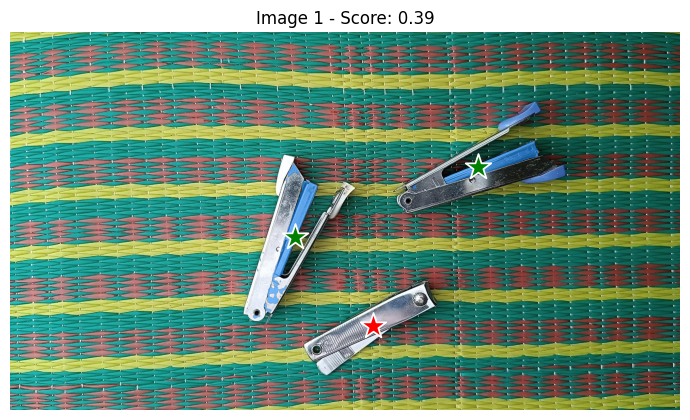

In [26]:
# SAM Masking by Points
def run_sam_with_points(images, point_pos):
  # colors = [
  #     (1, 0, 0),
  #     (0, 1, 0),
  #     (0, 0, 1),
  #     (1, 1, 0),
  #     (1, 0, 1),
  #     (0, 1, 1)
  # ]

  fig, axes = plt.subplots(1, len(images), figsize=(7 * len(images), 6))

  for i, img_name in enumerate(images):
    if len(images) == 1:
        ax = axes
    else:
        ax = axes[i]

    if img_name not in point_pos:
      continue

    image_path = os.path.join(image_folder, img_name)
    image = cv.imread(image_path)
    image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    ax.imshow(image_rgb)

    predictor.set_image(image_rgb)

    input_points = point_pos[img_name]["input_points"]
    input_labels = point_pos[img_name]["input_labels"]

    for j, (point, label) in enumerate(zip(input_points, input_labels)):

      point_array = np.array([point])
      label_array = np.array([label])

      masks, scores, logits = predictor.predict(
        point_coords=point_array,
        point_labels=label_array,
        multimask_output=False,
        )

      # cid = j % len(colors)

      sam_mask = masks[0].astype(np.uint8)
      show_mask(sam_mask, ax)

    show_points(input_points, input_labels, ax)
    ax.set_title(f"Image {i+1} - Score: {scores[0]:.2f}")
    ax.axis('off')

  plt.tight_layout()
  plt.show()


run_sam_with_points(selected_images, points)

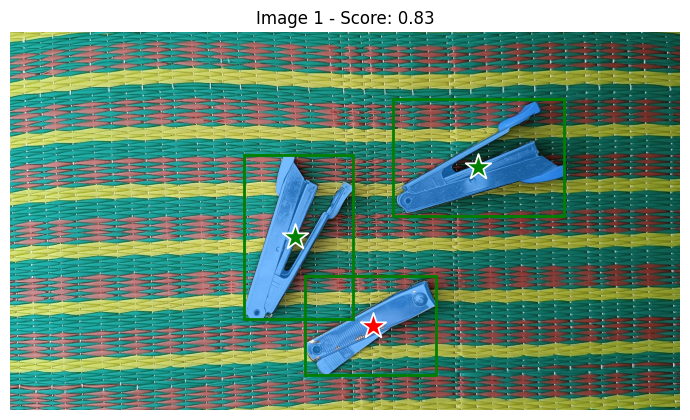

In [27]:
# SAM Masking by Boxes
def run_sam_with_boxes(images, point_pos, box_pos):
  fig, axes = plt.subplots(1, len(images), figsize=(7 * len(images), 6))

  for i, img_name in enumerate(images):
    if len(images) == 1:
        ax = axes
    else:
        ax = axes[i]

    if img_name not in point_pos:
      continue

    image_path = os.path.join(image_folder, img_name)
    image = cv.imread(image_path)
    image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    ax.imshow(image_rgb)

    predictor.set_image(image_rgb)

    input_points = point_pos[img_name]["input_points"]
    input_labels = point_pos[img_name]["input_labels"]
    box_array = box_pos[img_name]["input_boxes"]

    for j, (point, label, box) in enumerate(zip(input_points, input_labels, box_array)):

      point_array = np.array([point])
      label_array = np.array([label])
      box_array = np.array(box)

      masks, scores, logits = predictor.predict(
        point_coords=point_array,
        point_labels=label_array,
        box=box_array,
        multimask_output=False,
        )

      for mask in masks:
        show_mask(mask, ax)
      show_box(box_array, ax)

    show_points(input_points, input_labels, ax)
    ax.set_title(f"Image {i+1} - Score: {scores[0]:.2f}")
    ax.axis('off')

  plt.tight_layout()
  plt.show()

run_sam_with_boxes(selected_images, points, boxes)